# Burger equation in 1D

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (temporal boundary condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../..') # to import the package

Float64 and GPU settings

In [3]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [4]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [5]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [6]:
eqx_list = [
    [eqx.nn.Linear, 2, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

For the record and possible extensions, below is the way to create a PINN without the utility function.

In [7]:
# class MLP(eqx.Module):
#     layers: list

#     def __init__(self, key):
#         key1, key2, key3, key4 = random.split(key, 4)

#         self.layers = [
#             eqx.nn.Linear(2, 20, key=key1),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 20, key=key2),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 20, key=key3),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 1, key=key4),
#         ]
#     def __call__(self, t):
#         for layer in self.layers:
#             t = layer(t)
#         return t

# def make_mlp(key):
#     mlp = MLP(key) 
#     params, static = eqx.partition(mlp, eqx.is_inexact_array)

#     def init_fn():
#         return params

#     def apply_fn(t, x, u_params, eq_params=None): # NOTE here the unused eq_params
#         model = eqx.combine(u_params, static)
#         t_x = jnp.concatenate([t, x], axis=-1)
#         return model(t_x)[0]

#     return init_fn, apply_fn

In [8]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [9]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Let's plot the initial condition

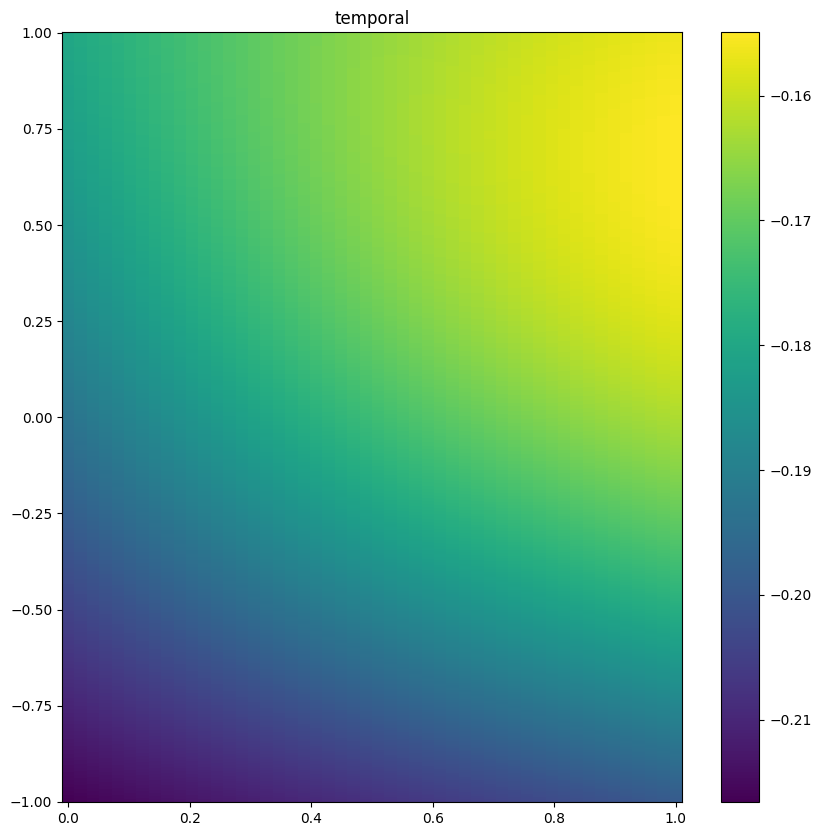

In [10]:
u_init = partial(u, u_params=init_nn_params)
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

## Model parameters

In [11]:
nu = 1 / (100 * jnp.pi)

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [12]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

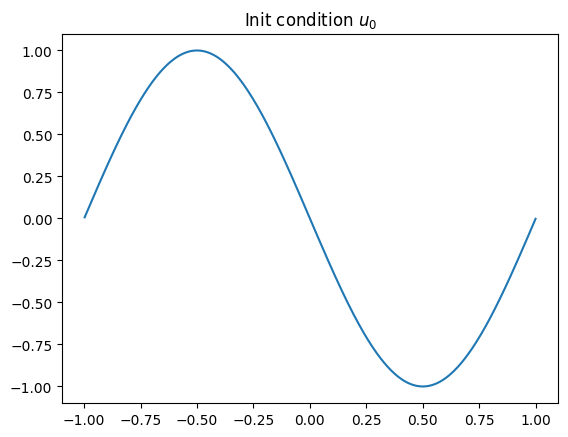

In [13]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

In [14]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)

In [15]:
loss_weights = {"dyn_loss":1, "temporal_loss":1, "boundary_loss":0.75}
    
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda dx: 0,
    omega_boundary_condition="dirichlet",
    temporal_boundary_fun=u0
)

In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 0.56
Individual losses: {'boundary_loss': '0.07', 'dyn_loss': '0.00', 'norm_loss': '0.00', 'observations': '0.00', 'temporal_loss': '0.51'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [17]:
params = init_params

In [18]:
# Optimizer
import optax
from jaxopt import OptaxSolver


tx = optax.adam(learning_rate=1e-3)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=50000)


In [19]:
n_iter = int(50000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

In [20]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data
)

Running for 50,000 iterations: 100%|████████████████| 50000/50000 [01:08<00:00, 731.44it/s]


## Results

Plot the loss values

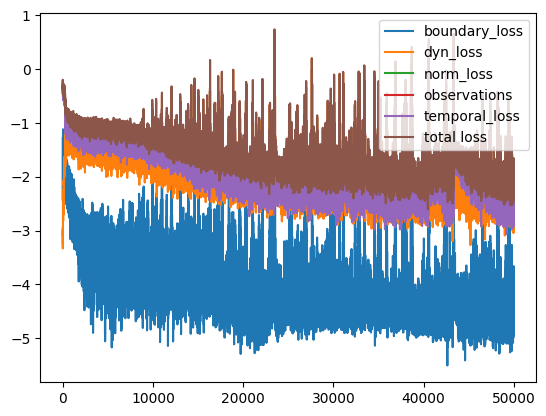

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

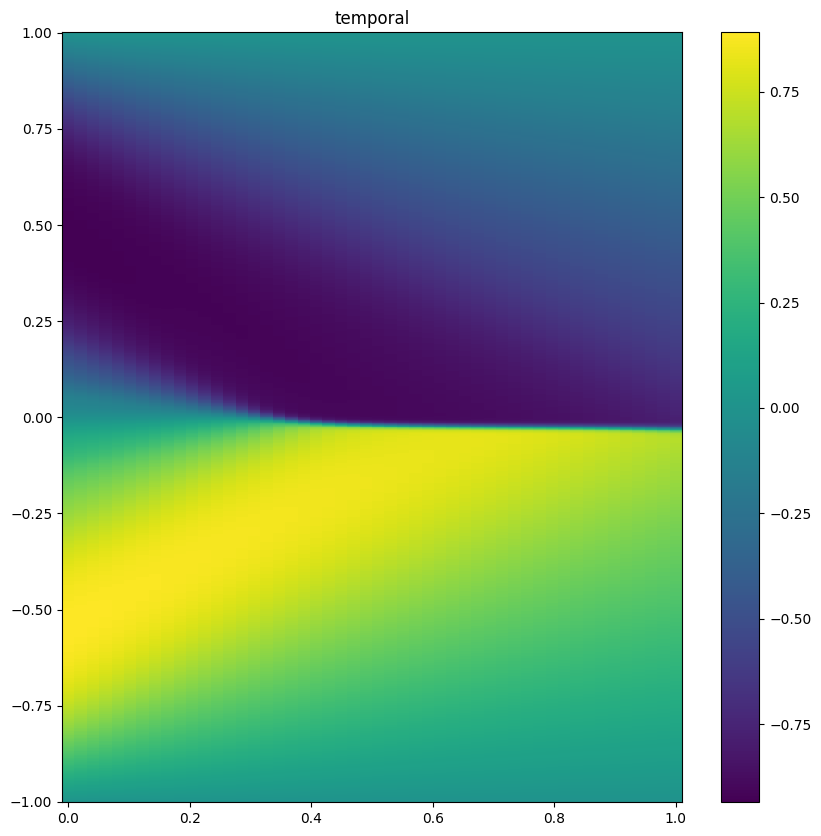

In [22]:
u_est = partial(u, u_params=params["nn_params"])

# same subkey
jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

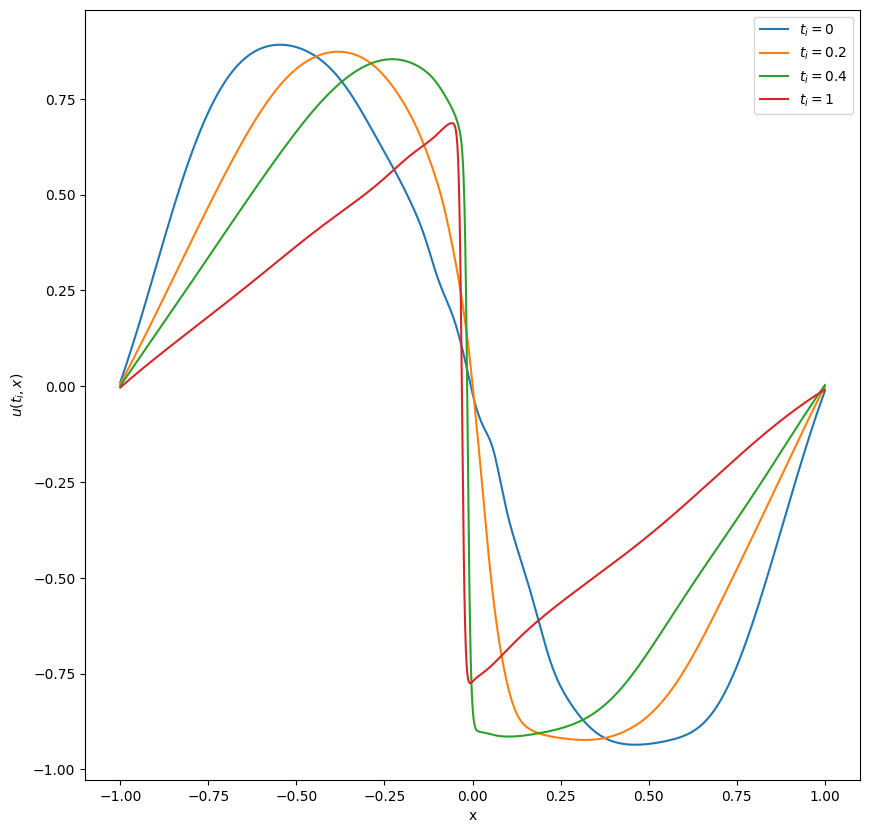

In [23]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)

Save the estimated solution grid values

In [24]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)
# jnp.save("burger_t_grid.npy", tv)
# jnp.save("burger_x_grid.npy", xv)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("burger_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )